# 2.1 신경망과의 첫 만남

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 2장 1절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

케라스 파이썬 라이브러리를 사용하여 손글씨 숫자 분류를 학습하는 구체적인 신경망 예제를 살펴보겠습니다.

지금 풀려는 문제는 흑백 손글씨 숫자 이미지(28×28픽셀)를 10개의 범주(0에서 9까지)로 분류하는 것입니다. 머신 러닝 커뮤니티에서 고전으로 취급받는 데이터셋인 MNIST를 사용하겠습니다. MNIST 문제를 알고리즘이 제대로 작동하는지 확인하기 위한 딥러닝계의 “hello world”라고 생각해도 됩니다.

![나타낼 수 없음](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/02fig01.jpg)  
_그림 2-1. MNIST 샘플 이미지_

MNIST 문제는 흑백 손글씨 숫자 이미지(28×28픽셀)를 10개의 범주(0에서 9까지)로 분류하는 것입니다. 1980년대 미국 국립표준기술연구소(NIST)에서 수집한 6만 개의 훈련 이미지와 1만 개의 테스트 이미지로 구성되어 있습니다.

---

**머신러닝에서의 클래스와 레이블** 

- **클래스(class)**: 분류 문제의 범주(category)[^1]
- **샘플(sample)**: 데이터 포인트
- **레이블(label)**: 특정 샘플의 클래스

---

[^1]: 혼동을 피하기 위해 프로그래밍 언어의 클래스를 의미하는 경우에는 ‘파이썬 클래스’나 ‘Sequential 클래스’처럼 명확하게 구분하여 부르겠습니다.

예제를 먼저 살펴보겠습니다.  
(당장 실습할 필요는 없습니다. 실습을 하시기 위해서는 3.3절의 케라스 환경을 먼저 설정해 주어야 합니다.)

keras에는 이미 넘파이(NumPy)[^2] 배열 형태로 mnist 데이터가 포함되어 있습니다.

[^2]: [넘파이](http://www.numpy.org/)는 파이썬의 대표적인 다차원 배열 라이브러리입니다. 케라스, 텐서플로, 사이킷런scikit-learn 등 많은 머신 러닝 라이브러리가 기본 데이터 구조로 넘파이 배열을 사용합니다.

In [2]:
# 코드 2-1. 케라스에서 MNIST 데이터셋 적재하기
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

각 요소를 살펴보면,

- `train_images`와 `train_labels`가 모델이 학습해야 할 **훈련 세트(training set)** [^3]
- 모델은 `test_images`와 `test_labels`로 구성된 **테스트 세트(test set)**에서 테스트될 것입니다.
- 이미지는 넘파이 배열로 인코딩되어 있고 레이블은 0부터 9까지의 숫자 배열입니다. 이미지와 레이블은 일대일 관계입니다.

[^3]: 전체 데이터셋(dataset)에서 훈련과 테스트 용도로 나눈 것을 훈련 세트(training set), 테스트 세트(test set)라고 부릅니다. 번역서에서 는 전체 set과 나눈 set를 구분하기 쉽도록 ‘셋’과 ‘세트’로 나누어 부르겠습니다.

데이터를 살펴봅시다.[^4]

[^4]: 이 책에서 ‘>>>’로 표시되어 있는 코드는 출력과 구분하기 위해서 사용되었습니다. 파이썬이나 IPython의 셸 프롬프트처럼 보이지만 주 피터 노트북에서 실습해도 무관합니다.

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
len(train_labels)

60000

In [5]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

다음은 테스트 데이터입니다:

In [6]:
test_images.shape

(10000, 28, 28)

In [7]:
len(test_labels)

10000

In [8]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

다섯 번째 샘플을 맷플롯립 라이브러리를 사용해 확인해 보겠습니다.

In [9]:
import matplotlib.pyplot as plt

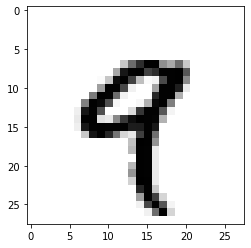

In [10]:
digit = train_images[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

작업 순서는 다음과 같습니다.

1. 훈련 데이터 train_images와 train_labels를 네트워크에 주입
2. 그러면 네트워크는 이미지와 레이블을 연관시킬 수 있도록 학습
3. test_images에 대한 예측을 네트워크에 요청, 이 예측이 test_labels와 맞는지 확인.

신경망을 만들어 보겠습니다.

In [11]:
# 코드 2-2. 신경망 구조
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

이 예제에서 각 층은 `relu`층과 `softmax`층입니다. `softmax`층의 경우는 10개의 확률 점수가 들어 있는 배열을 반환합니다.

신경망이 훈련 준비를 마치기 위해서는 컴파일 단계에 포함될 3가지가 더 필요합니다.[^5]

[^5]: compile() 메서드는 케라스가 씨아노의 래퍼wrapper 라이브러리로 시작되었음을 보여 주는 흔적입니다. 기본 백엔드backend인 텐서플로에서는 옵티마이저와 손실 함수, 측정 지표를 연결하여 계산 그래프computation graph 구성을 마무리하는 과정을 수행합니다.

- **손실 함수(loss function)**: 훈련 데이터에서 신경망의 성능을 측정하는 방법으로 네트워크가 옳은 방향으로 학습될 수 있도록 도와줍니다.
- **옵티마이저(optimizer)**: 입력된 데이터와 손실 함수를 기반으로 네트워크를 업데이트하는 메커니즘입니다.
- **훈련과 테스트 과정을 모니터링할 지표**: 여기에서는 정확도(정확히 분류된 이미지의 비율)만 고려하겠습니다.

손실 함수와 옵티마이저의 정확한 목적은 이어지는 2개의 장에서 자세히 설명합니다.

In [12]:
# 코드 2-3. 컴파일 단계
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

훈련을 시작하기 전에 데이터를 네트워크에 맞는 크기로 바꾸고 모든 값을 1로 정규화(normalization)합니다.[^6] 앞서 우리의 훈련 이미지는 [0 255] 범위의 uint8 타입으로 (60000, 28, 28) 크기를 가진 배열로 저장되어 있습니다. 이 데이터를 [0 1] 범위의 float32 타입으로 (60000, 28 * 28) 크기인 배열로 바꿉니다.

[^6]: 신경망은 입력 데이터의 스케일에 민감하여 적절한 데이터 전처리 과정이 필요합니다. 이미지의 경우 보통 픽셀의 최댓값인 255로 나누어 사용합니다.

In [13]:
# 코드 2-4. 이미지 데이터 준비하기
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

또한 레이블을 범주형으로 인코딩해야 합니다. 이 단계는 3장에서 자세히 살펴보겠습니다. [^7]

[^7]: 훈련 데이터의 개수가 n이고 클래스의 개수가 k일 때, to_categorical 함수는 입력받은 (n) 크기의 1차원 정수 배열을 (n, k) 크기의 2차원 배열로 변경합니다. 이 배열의 두 번째 차원의 인덱스가 클래스 값을 의미합니다. 예를 들어 to_categorical([0, 2])는 [[1, 0, 0], [0, 0, 1]]을 반환합니다. 3.5.2절에 이 함수의 구현 예가 있습니다.

In [14]:
# 코드 2-5. 레이블 준비하기
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

이제 준비가 되었습니다. 케라스에서는 `fit` 메서드를 호출하여 훈련 데이터에 모델을 학습시킵니다.

In [15]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.2556 - accuracy: 0.9265
Epoch 2/5
60000/60000 [==============================] - 2s 25us/step - loss: 0.1030 - accuracy: 0.9696
Epoch 3/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.0673 - accuracy: 0.9800
Epoch 4/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.0487 - accuracy: 0.9850
Epoch 5/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.0370 - accuracy: 0.9885


훈련하는 동안 2개의 정보가 출력됩니다. 훈련 데이터에 대한 네트워크의 손실과 정확도입니다. 훈련시에 정확도는 98.94%까지 증가함을 알 수 있습니다.

In [16]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 52us/step


In [17]:
print('test_acc:', test_acc)

test_acc: 0.9793000221252441


그리고 테스트의 정확도는 97.93%가 나왔습니다. 훈련의 정확도 보다 약간 낮습니다. 이런 정확도의 차이는 **과대적합(overfitting)** 때문입니다. 과대적합은 3장에서 자세하게 논의합니다.